## Region init

In [1]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_parquet('data/_towns.parquet')
settlements = gpd.read_parquet('data/_okrugs.parquet')
districts = gpd.read_parquet('data/_rayons.parquet')
adj_mx = pd.read_pickle('data/adj_mx.pkl')

In [3]:
districts.to_crs(4326).to_file('data/regions/1/districts.geojson')
settlements.to_crs(4326).to_file('data/regions/1/settlements.geojson')
towns.to_crs(4326).to_file('data/regions/1/towns.geojson')

In [2]:
adj_mx

,0,1,2,3,4,5,6,7,8,9,...,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930
0,0.000000,11.687417,12.024583,10.793467,7.706417,3.430783,21.595867,28.751767,8.414917,17.122383,...,175.058750,167.140183,165.007050,170.280017,195.283250,195.283250,188.983383,172.762700,171.419367,183.309833
1,11.687417,0.000000,0.337167,4.313350,17.966250,13.690617,29.636783,36.792683,16.455833,10.347433,...,163.992767,156.074200,153.941067,159.214033,184.217267,184.217267,177.917400,161.696717,160.353383,172.243850
2,12.024583,0.337167,0.000000,4.650517,18.303417,14.027783,29.973950,37.129850,16.246817,10.684600,...,163.655600,155.737033,153.603900,158.876867,183.880100,183.880100,177.580233,161.359550,160.016217,171.906683
3,10.793467,4.313350,4.650517,0.000000,17.072300,12.796667,28.742833,35.898733,15.561883,9.748317,...,167.684683,159.766117,157.632983,162.905950,187.909183,187.909183,181.609317,165.388633,164.045300,175.935767
4,7.706417,17.966250,18.303417,17.072300,0.000000,4.275633,27.874700,35.030600,14.693750,23.401217,...,181.337583,173.419017,171.285883,176.558850,201.562083,201.562083,195.262217,179.041533,177.698200,189.588667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,195.415117,184.349133,184.011967,188.041050,201.693950,197.418317,213.364483,220.520383,197.755433,194.075133,...,24.994667,29.116733,31.821667,32.256567,0.000000,0.000000,17.445683,39.577317,38.233983,32.094983
2927,189.115233,178.049250,177.712083,181.741167,195.394067,191.118433,207.064600,214.220500,191.455550,187.775250,...,17.941683,22.063750,24.768683,25.203583,17.445683,17.445683,0.000000,32.524333,31.181000,25.042000
2928,172.898933,161.832950,161.495783,165.524867,179.177767,174.902133,190.848300,198.004200,175.239250,171.558950,...,18.604083,10.685517,7.755650,13.825350,39.581700,39.581700,32.528717,0.000000,1.343333,26.855167
2929,171.555600,160.489617,160.152450,164.181533,177.834433,173.558800,189.504967,196.660867,173.895917,170.215617,...,17.260750,9.342183,6.412317,12.482017,38.238367,38.238367,31.185383,1.343333,0.000000,25.511833


In [3]:
territories = [gpd.read_file(f'data/territories/{terr}.geojson') for terr in ['lodey', 'shlis', 'siver', 'sveto']]
territories = pd.concat(territories).reset_index(drop=True).to_crs(towns.crs)

In [4]:
from townsnet.models.region import Region

region = Region(
  districts=districts, 
  settlements=settlements, 
  towns=towns,
  accessibility_matrix=adj_mx,
  territories=territories
)

In [5]:
region.get_service_types_df().head()

,category,infrastructure,name,name_ru,weight,accessibility,demand
0,BASIC,EDUCATION,kindergarten,детский сад,0.2,7,61
1,BASIC,EDUCATION,school,школа,0.2,15,120
2,BASIC,HEALTHCARE,health_center/dispensary,ФАП / амбулатория,0.2,10,13
3,BASIC,HEALTHCARE,pharmacy,аптека,0.2,15,15
4,BASIC,COMMERCE,convenience,продуктовый магазин,0.2,5,180


In [6]:
region.get_territories_gdf()

,name,geometry
id,,
0,Аэродром Лодейнопольское поселение,"POLYGON ((529877.020 6730827.593, 529893.182 6..."
1,Проект Шлиссельбург,"POLYGON ((387861.999 6644712.938, 388202.551 6..."
2,Аэродром Сиверский,"POLYGON ((329788.882 6583309.434, 330250.950 6..."
3,Проект Светогорское поселение,"POLYGON ((278277.965 6784490.204, 279737.375 6..."


## Fill service types data

In [7]:
import osmnx as ox
from multiprocessing import Pool

polygon = region.geometry

def fetch(service_type):
  try:
    gdf = ox.features_from_polygon(polygon, tags=service_type.osm_tags).reset_index().to_crs(region.crs)
  except:
    gdf = None
  return service_type.name, gdf

pool = Pool()
gdfs = {st:gdf for st, gdf in pool.map(fetch, region.service_types)}

In [8]:
for st, gdf in gdfs.items():
  if gdf is not None:
    print(st)

kindergarten
school
health_center/dispensary
pharmacy
convenience
houseware
cafe/coffee
universal_hall
playground
square/boulevard/forest_park
workout/school_gym
delivery_point/post_office
hairdresser/beauty
public_transport_stop
parking
local_police
community_center
polyclinic
local_hospital
supermarket
zoo
bar_restaurant
community_centre_culture_house
public_space
park
gym/fitness_center
skatepark/workout_for_teenagers
bank
gas_station
police_supporting_point
art_school
city_hospital
commercial_clinic
hypermarket
food_court
library
cult_object
amusement_park
dog_park
swimming_pool
railway_station
car_service
fire_station


In [9]:
for service_type, gdf in gdfs.items():
  if gdf is not None:
    gdf = region.match_services_towns(gdf)
    gdf['capacity'] = 250
    gdf.geometry = gdf.representative_point()
    region.update_services(service_type, gdf)

In [10]:
region.get_services_gdf()

,town,service_type,geometry,capacity
0,Бор,kindergarten,POINT (545062.236 6592984.549),250
1,Бор,school,POINT (545003.453 6592946.638),250
2,Бор,cafe/coffee,POINT (545057.111 6593074.763),250
3,Дмитрово,public_transport_stop,POINT (556606.517 6570799.269),250
4,Ларьян,school,POINT (543946.962 6596292.051),250
...,...,...,...,...
26597,Апраксин Бор,public_transport_stop,POINT (399227.549 6560566.367),250
26598,Апраксин Бор,public_transport_stop,POINT (399216.723 6560632.806),250
26599,Большая Горка,public_transport_stop,POINT (413170.857 6573826.061),250
26600,Большая Горка,parking,POINT (413177.388 6573887.691),250


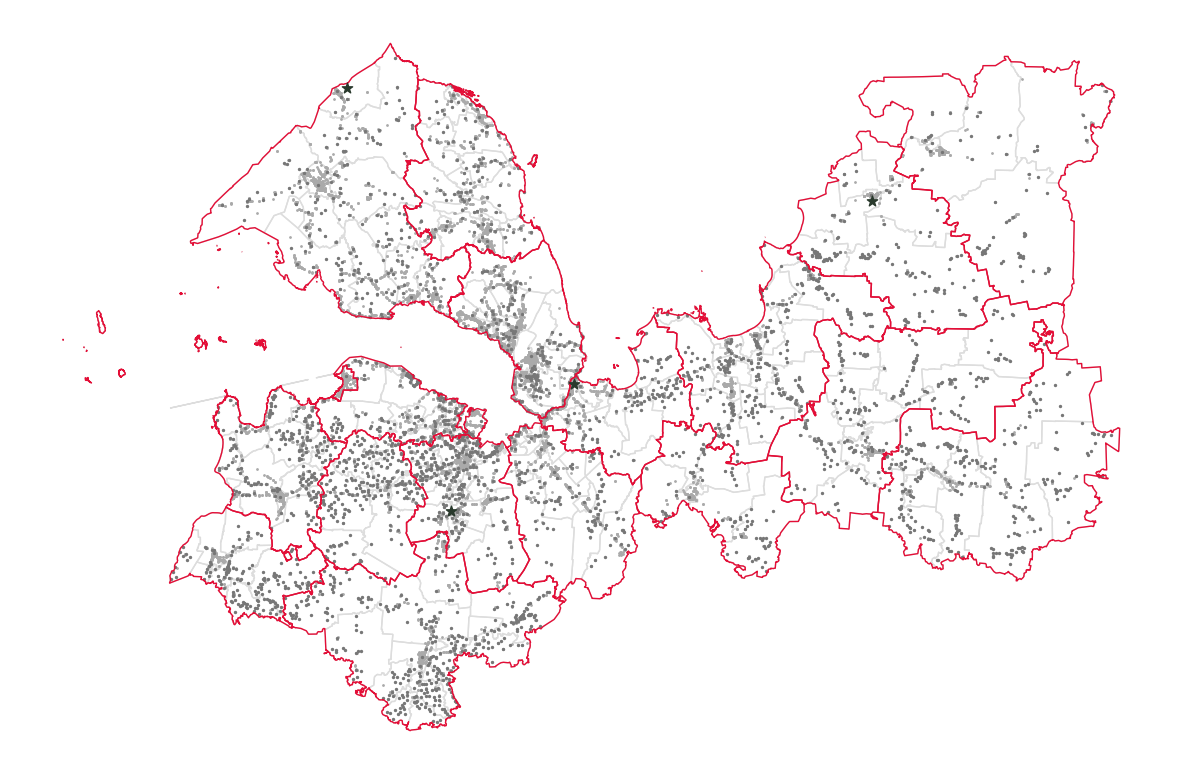

In [11]:
region.plot()

In [12]:
region.to_pickle('data/region.pickle')